Dataset: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=transactions.csv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_all_data():
    """
    Load all datasets and print basic information about each
    """
    print("Loading all datasets...\n")

    # Load train.csv - contains id and date
    train = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
    print("\nTraining Data:")
    print(f"Shape: {train.shape}")
    print("\nColumns:", train.columns.tolist())
    print("\nFirst few rows:")
    print(train.head())
    print("\nData Info:")
    print(train.info())
    print("\nMissing Values:")
    print(train.isnull().sum())
    print("\n" + "="*50)

    # Load test.csv - contains id and date
    test = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
    print("\nTest Data:")
    print(f"Shape: {test.shape}")
    print("\nColumns:", test.columns.tolist())
    print("\nFirst few rows:")
    print(test.head())
    print("\nData Info:")
    print(test.info())
    print("\nMissing Values:")
    print(test.isnull().sum())
    print("\n" + "="*50)

    # Load stores.csv - no date column
    stores = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/stores.csv')
    print("\nStores Data:")
    print(f"Shape: {stores.shape}")
    print("\nColumns:", stores.columns.tolist())
    print("\nFirst few rows:")
    print(stores.head())
    print("\nData Info:")
    print(stores.info())
    print("\nMissing Values:")
    print(stores.isnull().sum())
    print("\nUnique values in each column:")
    for col in stores.columns:
        print(f"{col}: {stores[col].nunique()} unique values")
    print("\n" + "="*50)

    # Load oil.csv - contains date
    oil = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
    print("\nOil Prices Data:")
    print(f"Shape: {oil.shape}")
    print("\nColumns:", oil.columns.tolist())
    print("\nFirst few rows:")
    print(oil.head())
    print("\nData Info:")
    print(oil.info())
    print("\nMissing Values:")
    print(oil.isnull().sum())
    print("\n" + "="*50)

    # Load holidays_events.csv - contains date
    holidays = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
    print("\nHolidays/Events Data:")
    print(f"Shape: {holidays.shape}")
    print("\nColumns:", holidays.columns.tolist())
    print("\nFirst few rows:")
    print(holidays.head())
    print("\nData Info:")
    print(holidays.info())
    print("\nMissing Values:")
    print(holidays.isnull().sum())
    print("\nUnique values in type column:")
    print(holidays['type'].unique())
    print("\n" + "="*50)

    return train, test, stores, oil, holidays

# Add helper function to get quick summary of a dataset
def get_dataset_summary(df, name):
    """
    Print a quick summary of key dataset characteristics
    """
    print(f"\nQuick Summary of {name}:")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    if 'date' in df.columns:
        print(f"Date range: from {df['date'].min()} to {df['date'].max()}")

if __name__ == "__main__":
    train, test, stores, oil, holidays = load_all_data()

    # Get quick summaries
    print("\nDATASET SUMMARIES:")
    get_dataset_summary(train, "Training Data")
    get_dataset_summary(test, "Test Data")
    get_dataset_summary(stores, "Stores Data")
    get_dataset_summary(oil, "Oil Prices Data")
    get_dataset_summary(holidays, "Holidays/Events Data")

Loading all datasets...


Training Data:
Shape: (3000888, 6)

Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']

First few rows:
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None

Missing Value

# **Exploratory Data Analysis**

In [4]:
def analyze_sales_patterns(train_df):
    """
    Analyze basic sales patterns and statistics
    """
    print("\nANALYZING SALES PATTERNS")
    print("=" * 50)

    # Overall sales statistics
    print("\nOverall Sales Statistics:")
    sales_stats = train_df['sales'].describe()
    print(sales_stats)
    print(f"\nTotal Sales: ${train_df['sales'].sum():,.2f}")
    print(f"Number of Zero Sales: {(train_df['sales'] == 0).sum():,} ({(train_df['sales'] == 0).mean():.2%} of total)")

    # Sales by store with store metadata
    print("\nStore Sales Summary (Top 10 Stores by Average Sales):")
    store_sales = train_df.groupby('store_nbr').agg({
        'sales': ['mean', 'std', 'count', 'sum'],
        'onpromotion': 'sum'
    }).round(2)
    store_sales.columns = ['avg_sales', 'std_sales', 'transaction_count', 'total_sales', 'total_promotions']
    print(store_sales.sort_values('avg_sales', ascending=False).head(10))

    # Sales by product family
    print("\nProduct Family Sales Summary (Top 10 Families):")
    family_sales = train_df.groupby('family').agg({
        'sales': ['mean', 'std', 'count', 'sum'],
        'onpromotion': 'sum'
    }).round(2)
    family_sales.columns = ['avg_sales', 'std_sales', 'transaction_count', 'total_sales', 'total_promotions']
    print(family_sales.sort_values('total_sales', ascending=False).head(10))

    return store_sales, family_sales


In [5]:
def analyze_promotions(train_df):
    """
    Analyze the impact of promotions on sales
    """
    print("\nANALYZING PROMOTION IMPACT")
    print("=" * 50)

    # Compare sales with and without promotions
    print("\nSales Statistics by Promotion Status:")
    promo_impact = train_df.groupby('onpromotion').agg({
        'sales': ['mean', 'std', 'count', 'sum'],
        'family': 'nunique'
    }).round(2)
    promo_impact.columns = ['avg_sales', 'std_sales', 'transaction_count', 'total_sales', 'unique_families']
    print(promo_impact)

    # Promotion analysis by product family
    print("\nTop 10 Product Families by Promotion Frequency:")
    promo_by_family = train_df.groupby('family').agg({
        'onpromotion': ['mean', 'sum'],
        'sales': ['mean', 'sum']
    }).round(4)
    promo_by_family.columns = ['promo_frequency', 'total_promos', 'avg_sales', 'total_sales']
    promo_by_family['sales_per_promo'] = (promo_by_family['total_sales'] /
                                         promo_by_family['total_promos']).round(2)
    print(promo_by_family.sort_values('promo_frequency', ascending=False).head(10))

    return promo_impact, promo_by_family


In [6]:
def analyze_temporal_patterns(train_df):
    """
    Analyze temporal patterns in sales
    """
    print("\nANALYZING TEMPORAL PATTERNS")
    print("=" * 50)

    # Add time-based features
    train_df['year'] = train_df['date'].dt.year
    train_df['month'] = train_df['date'].dt.month
    train_df['day_of_week'] = train_df['date'].dt.dayofweek
    train_df['day_of_month'] = train_df['date'].dt.day

    # Yearly patterns
    print("\nYearly Sales Patterns:")
    yearly_sales = train_df.groupby('year').agg({
        'sales': ['mean', 'sum', 'count'],
        'onpromotion': 'sum'
    }).round(2)
    yearly_sales.columns = ['avg_sales', 'total_sales', 'transaction_count', 'total_promotions']
    print(yearly_sales)

    # Monthly patterns
    print("\nMonthly Sales Patterns:")
    monthly_sales = train_df.groupby('month').agg({
        'sales': ['mean', 'sum', 'count'],
        'onpromotion': 'sum'
    }).round(2)
    monthly_sales.columns = ['avg_sales', 'total_sales', 'transaction_count', 'total_promotions']
    print(monthly_sales)

    # Day of week patterns
    print("\nDay of Week Sales Patterns:")
    dow_sales = train_df.groupby('day_of_week').agg({
        'sales': ['mean', 'sum', 'count'],
        'onpromotion': 'sum'
    }).round(2)
    dow_sales.columns = ['avg_sales', 'total_sales', 'transaction_count', 'total_promotions']
    print(dow_sales)

    # Day of month patterns
    print("\nDay of Month Sales Patterns (Top 5 and Bottom 5 Days):")
    dom_sales = train_df.groupby('day_of_month').agg({
        'sales': ['mean', 'sum', 'count'],
        'onpromotion': 'sum'
    }).round(2)
    dom_sales.columns = ['avg_sales', 'total_sales', 'transaction_count', 'total_promotions']
    print("\nTop 5 Days:")
    print(dom_sales.sort_values('avg_sales', ascending=False).head())
    print("\nBottom 5 Days:")
    print(dom_sales.sort_values('avg_sales', ascending=True).head())

    return {
        'yearly': yearly_sales,
        'monthly': monthly_sales,
        'dow': dow_sales,
        'dom': dom_sales
    }


In [7]:
def main():
    """
    Main function to run all analyses
    """
    # Load data
    train, test, stores, oil, holidays = load_all_data()

    # Run analyses
    print("\nRunning comprehensive EDA...\n")
    store_sales, family_sales = analyze_sales_patterns(train)
    promo_impact, promo_by_family = analyze_promotions(train)
    temporal_patterns = analyze_temporal_patterns(train)

    print("\nInitial EDA complete. Ready for visualization and further analysis.")

    return {
        'train': train,
        'test': test,
        'stores': stores,
        'oil': oil,
        'holidays': holidays,
        'analysis': {
            'store_sales': store_sales,
            'family_sales': family_sales,
            'promo_impact': promo_impact,
            'promo_by_family': promo_by_family,
            'temporal_patterns': temporal_patterns
        }
    }

if __name__ == "__main__":
    results = main()

Loading all datasets...


Training Data:
Shape: (3000888, 6)

Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']

First few rows:
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None

Missing Value

In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
stores_df = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/stores.csv')
oil_df = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays_df = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])


In [9]:
def plot_sales_distribution(train_df, stores_df):
    """
    Create visualizations for sales distribution
    """
    plt.figure(figsize=(20, 12))

    # Plot 1: Sales distribution (excluding zeros)
    plt.subplot(2, 2, 1)
    non_zero_sales = train_df[train_df['sales'] > 0]['sales']
    sns.histplot(data=non_zero_sales, bins=50)
    plt.title('Sales Distribution (Excluding Zeros)')
    plt.xlabel('Sales')
    plt.yscale('log')

    # Plot 2: Box plot of sales by store type
    plt.subplot(2, 2, 2)
    store_type_sales = train_df.merge(stores_df[['store_nbr', 'type']], on='store_nbr', how='left')
    sns.boxplot(data=store_type_sales, x='type', y='sales')
    plt.title('Sales Distribution by Store Type')
    plt.xticks(rotation=45)

    # Plot 3: Top 10 product families by total sales
    plt.subplot(2, 2, 3)
    top_families = train_df.groupby('family')['sales'].sum().nlargest(10)
    sns.barplot(x=top_families.values, y=top_families.index)
    plt.title('Top 10 Product Families by Total Sales')

    # Plot 4: Zero vs Non-zero sales distribution
    plt.subplot(2, 2, 4)
    zero_sales = (train_df['sales'] == 0).sum()
    non_zero_sales = (train_df['sales'] > 0).sum()
    plt.pie([zero_sales, non_zero_sales],
            labels=['Zero Sales', 'Non-zero Sales'],
            autopct='%1.1f%%')
    plt.title('Zero vs Non-zero Sales Distribution')

    plt.tight_layout()
    plt.savefig('sales_distribution.png')
    plt.show()


In [10]:
def plot_temporal_patterns(train_df):
    """
    Create visualizations for temporal patterns
    """
    plt.figure(figsize=(20, 12))

    # Plot 1: Average sales by year
    plt.subplot(2, 2, 1)
    yearly_sales = train_df.groupby(train_df['date'].dt.year)['sales'].mean()
    plt.plot(yearly_sales.index, yearly_sales.values, 'o-')
    plt.title('Average Sales by Year')
    plt.grid(True)

    # Plot 2: Average sales by month
    plt.subplot(2, 2, 2)
    monthly_sales = train_df.groupby(train_df['date'].dt.month)['sales'].mean()
    plt.plot(monthly_sales.index, monthly_sales.values, 'o-')
    plt.title('Average Sales by Month')
    plt.grid(True)

    # Plot 3: Average sales by day of week
    plt.subplot(2, 2, 3)
    dow_sales = train_df.groupby(train_df['date'].dt.dayofweek)['sales'].mean()
    sns.barplot(x=dow_sales.index, y=dow_sales.values)
    plt.title('Average Sales by Day of Week')
    plt.xlabel('Day of Week (0=Monday)')

    # Plot 4: Monthly sales trend
    plt.subplot(2, 2, 4)
    monthly_trend = train_df.groupby('date')['sales'].mean().rolling(window=30).mean()
    plt.plot(monthly_trend.index, monthly_trend.values)
    plt.title('30-Day Rolling Average Sales')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig("temporal_patterns.png")
    plt.show()

In [11]:
def analyze_missing_values(train_df, oil_df, stores_df, holidays_df):
    """
    Analyze and visualize missing values
    """
    plt.figure(figsize=(15, 6))

    # Plot 1: Missing oil prices over time
    plt.subplot(1, 2, 1)
    plt.plot(oil_df['date'], oil_df['dcoilwtico'], '-o', alpha=0.5)
    plt.title('Oil Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Oil Price')
    plt.xticks(rotation=45)

    # Plot 2: Missing values percentage
    plt.subplot(1, 2, 2)
    missing_data = pd.DataFrame({
        'Oil_Prices': [oil_df['dcoilwtico'].isnull().sum() / len(oil_df) * 100],
        'Sales': [train_df['sales'].isnull().sum() / len(train_df) * 100],
        'Promotions': [train_df['onpromotion'].isnull().sum() / len(train_df) * 100]
    }, index=['Missing_Percentage'])

    sns.heatmap(missing_data, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Missing Values Percentage by Feature')

    plt.tight_layout()
    plt.savefig('missing_values.png')
    plt.show()

    # Print missing value analysis
    print("\nMissing Values Analysis:")
    print("=" * 50)
    print(f"Oil Prices: {oil_df['dcoilwtico'].isnull().sum()} missing values")
    print(f"Sales: {train_df['sales'].isnull().sum()} missing values")
    print(f"Promotions: {train_df['onpromotion'].isnull().sum()} missing values")

    # Additional analysis for oil prices missing values
    print("\nOil Prices Missing Values Pattern:")
    missing_oil_dates = oil_df[oil_df['dcoilwtico'].isnull()]['date']
    print(f"Date range of missing values: {missing_oil_dates.min()} to {missing_oil_dates.max()}")
    print(f"Number of consecutive days with missing values: {len(missing_oil_dates)}")

In [12]:
def detect_outliers(train_df):
    """
    Detect and visualize outliers in sales data
    """
    plt.figure(figsize=(20, 12))

    # Calculate outlier thresholds
    Q1 = train_df['sales'].quantile(0.25)
    Q3 = train_df['sales'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Plot 1: Box plot of sales by product family
    plt.subplot(2, 2, 1)
    sns.boxplot(data=train_df, x='family', y='sales')
    plt.xticks(rotation=90)
    plt.title('Sales Distribution by Product Family')

    # Plot 2: Scatter plot of sales vs promotions
    plt.subplot(2, 2, 2)
    plt.scatter(train_df['onpromotion'], train_df['sales'],
               alpha=0.1, c='blue', label='Normal')
    outliers = train_df[train_df['sales'] > upper_bound]
    plt.scatter(outliers['onpromotion'], outliers['sales'],
               alpha=0.5, c='red', label='Outliers')
    plt.axhline(y=upper_bound, color='r', linestyle='--',
                label=f'Upper Bound ({upper_bound:.2f})')
    plt.legend()
    plt.title('Sales vs Promotions (Outliers Highlighted)')

    # Plot 3: Distribution of outliers by product family
    plt.subplot(2, 2, 3)
    outliers_by_family = outliers.groupby('family').size().sort_values(ascending=True)
    sns.barplot(x=outliers_by_family.values, y=outliers_by_family.index)
    plt.title('Number of Outliers by Product Family')

    # Plot 4: Outliers over time
    plt.subplot(2, 2, 4)
    outliers_by_date = outliers.groupby('date').size()
    plt.plot(outliers_by_date.index, outliers_by_date.values)
    plt.title('Number of Outliers Over Time')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('outliers.png')
    plt.show()

    # Print outlier statistics
    print("\nOutlier Analysis:")
    print("=" * 50)
    print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(train_df)*100:.2f}% of data)")
    print(f"\nOutlier Thresholds:")
    print(f"Lower bound: {lower_bound:.2f}")
    print(f"Upper bound: {upper_bound:.2f}")
    print("\nOutlier Statistics:")
    print(outliers['sales'].describe())

Creating sales distribution visualizations...


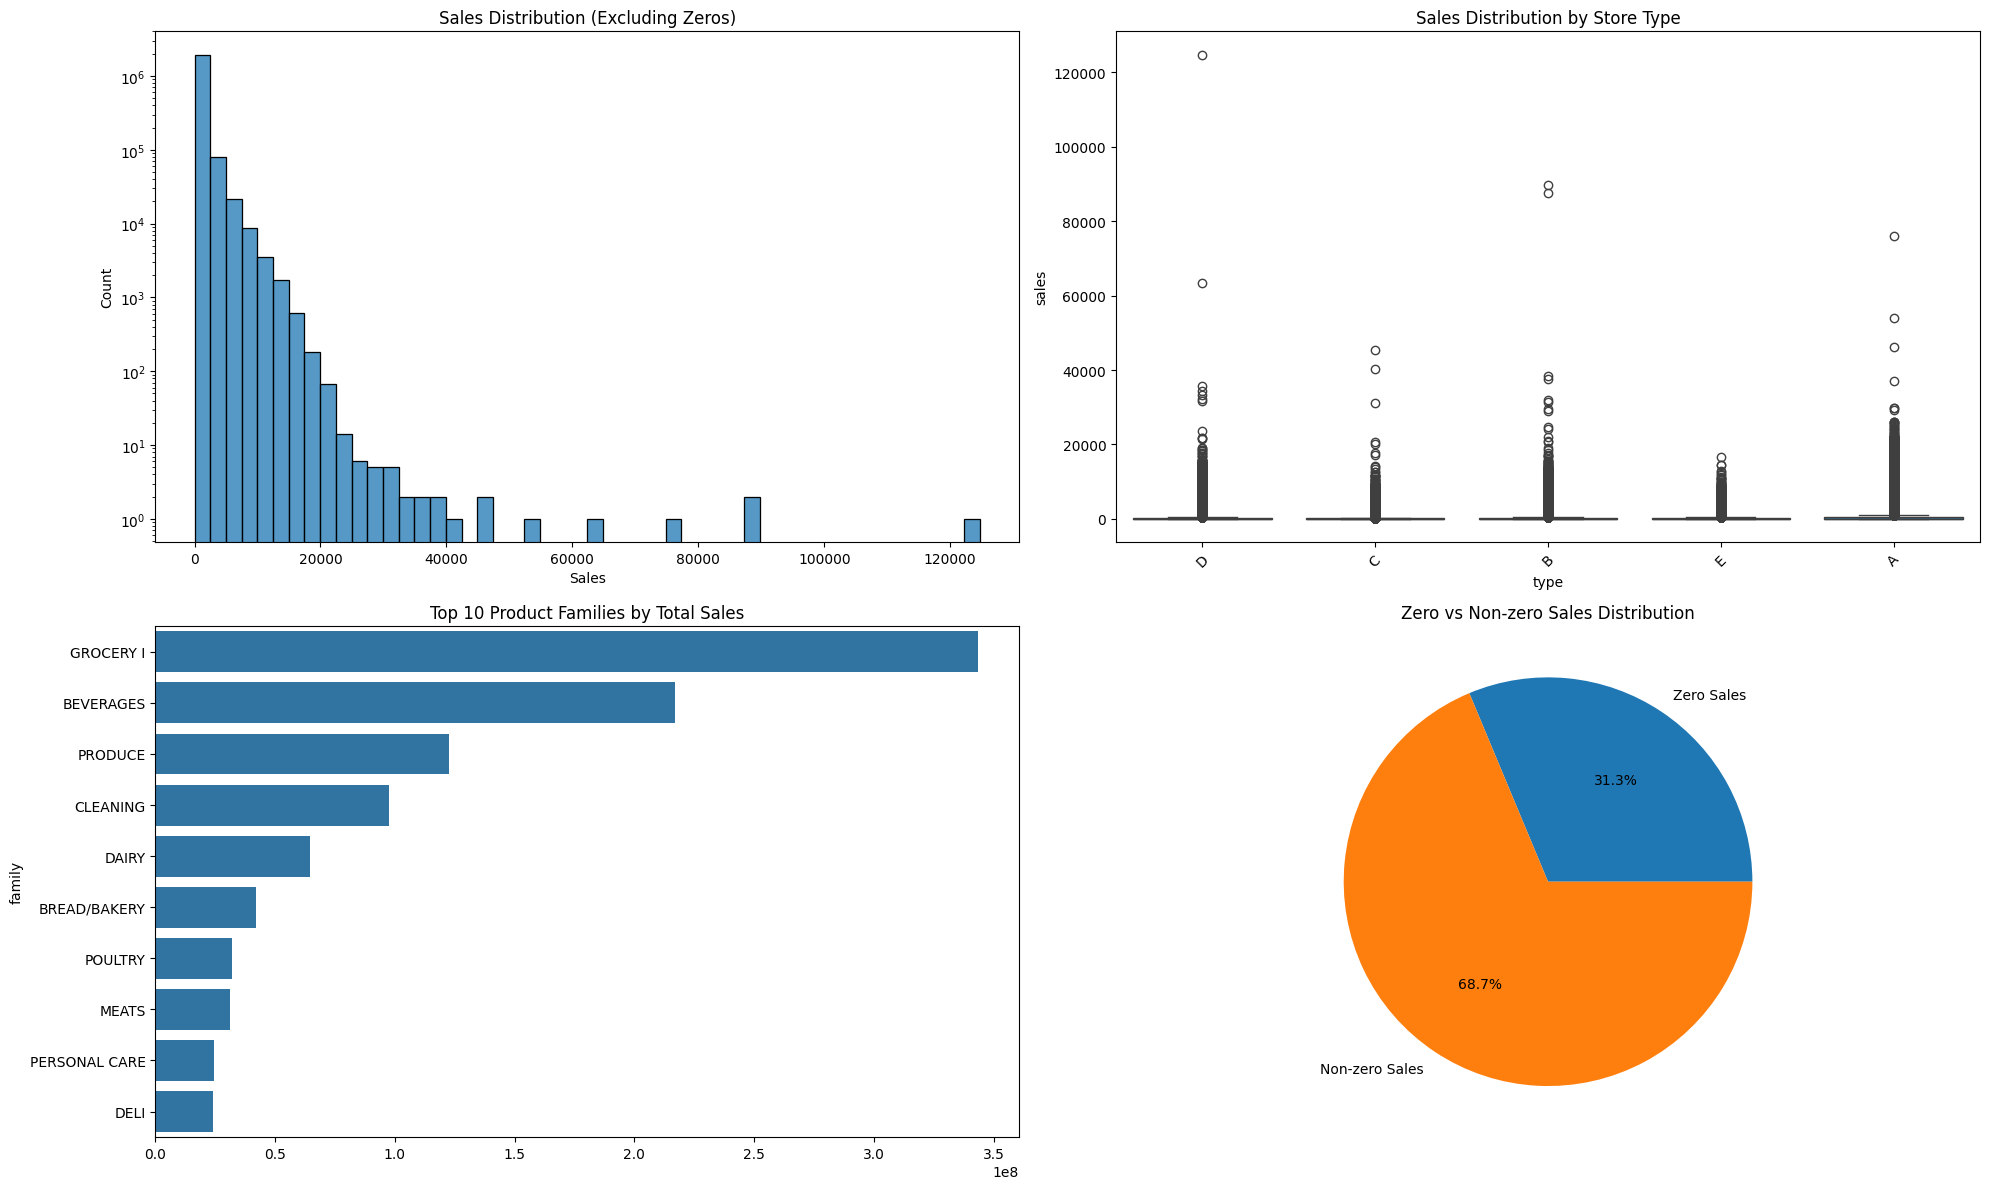


Creating temporal pattern visualizations...


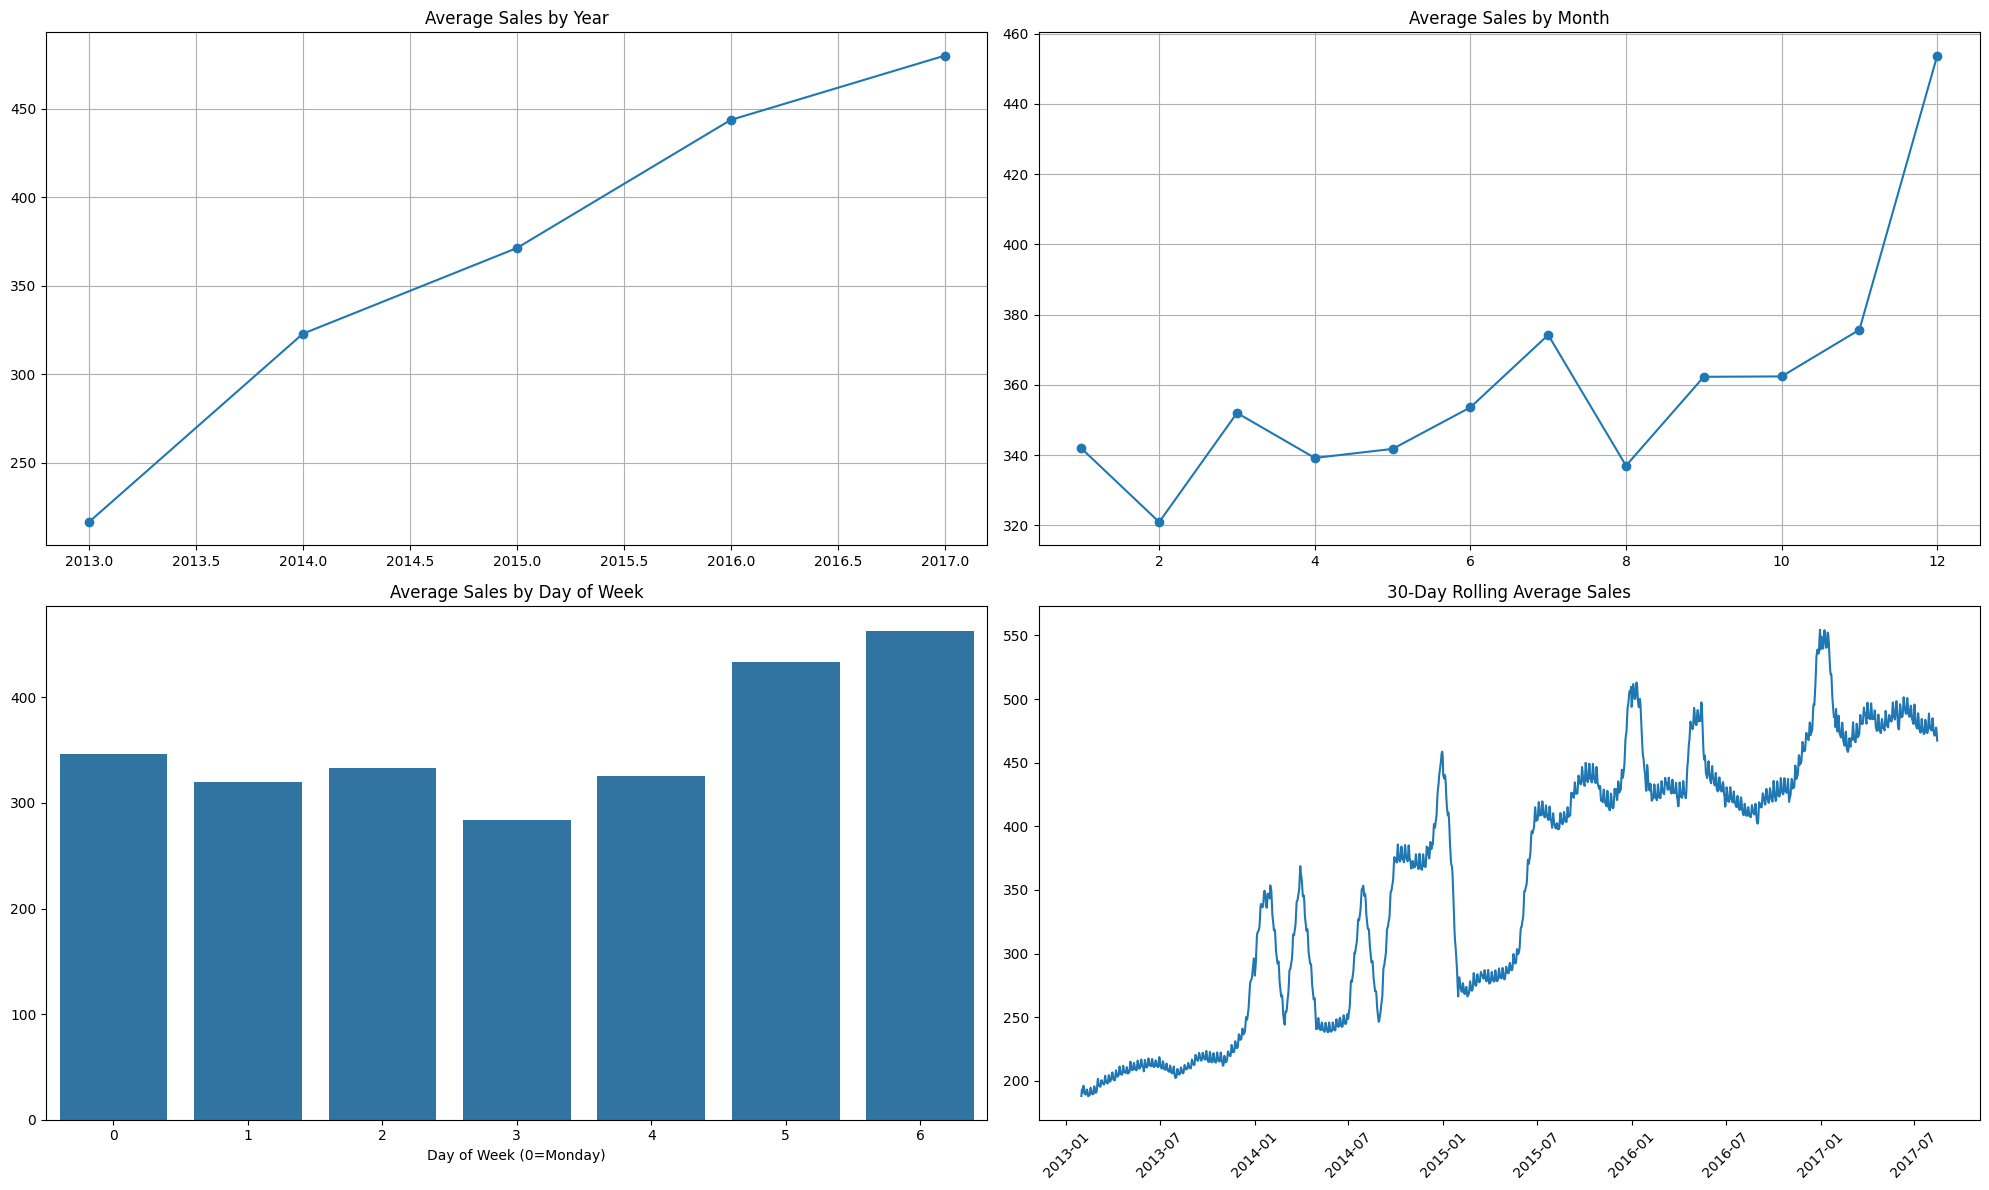


Analyzing missing values...


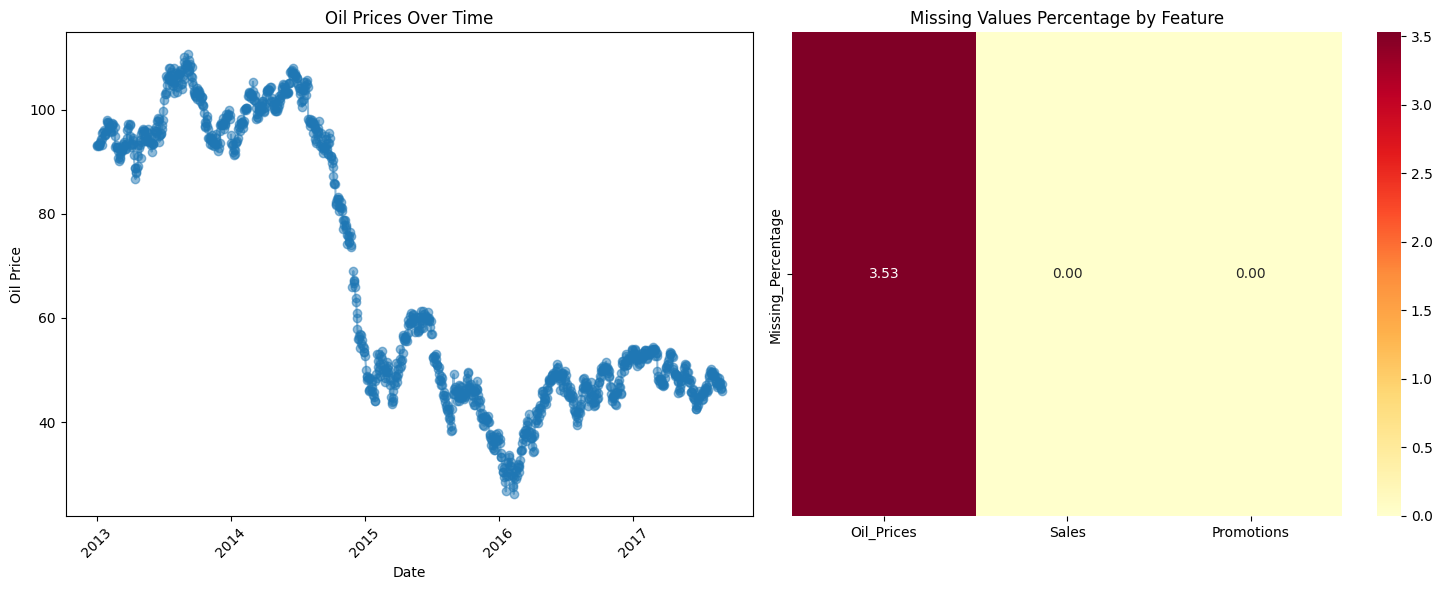


Missing Values Analysis:
Oil Prices: 43 missing values
Sales: 0 missing values
Promotions: 0 missing values

Oil Prices Missing Values Pattern:
Date range of missing values: 2013-01-01 00:00:00 to 2017-07-04 00:00:00
Number of consecutive days with missing values: 43

Detecting and visualizing outliers...


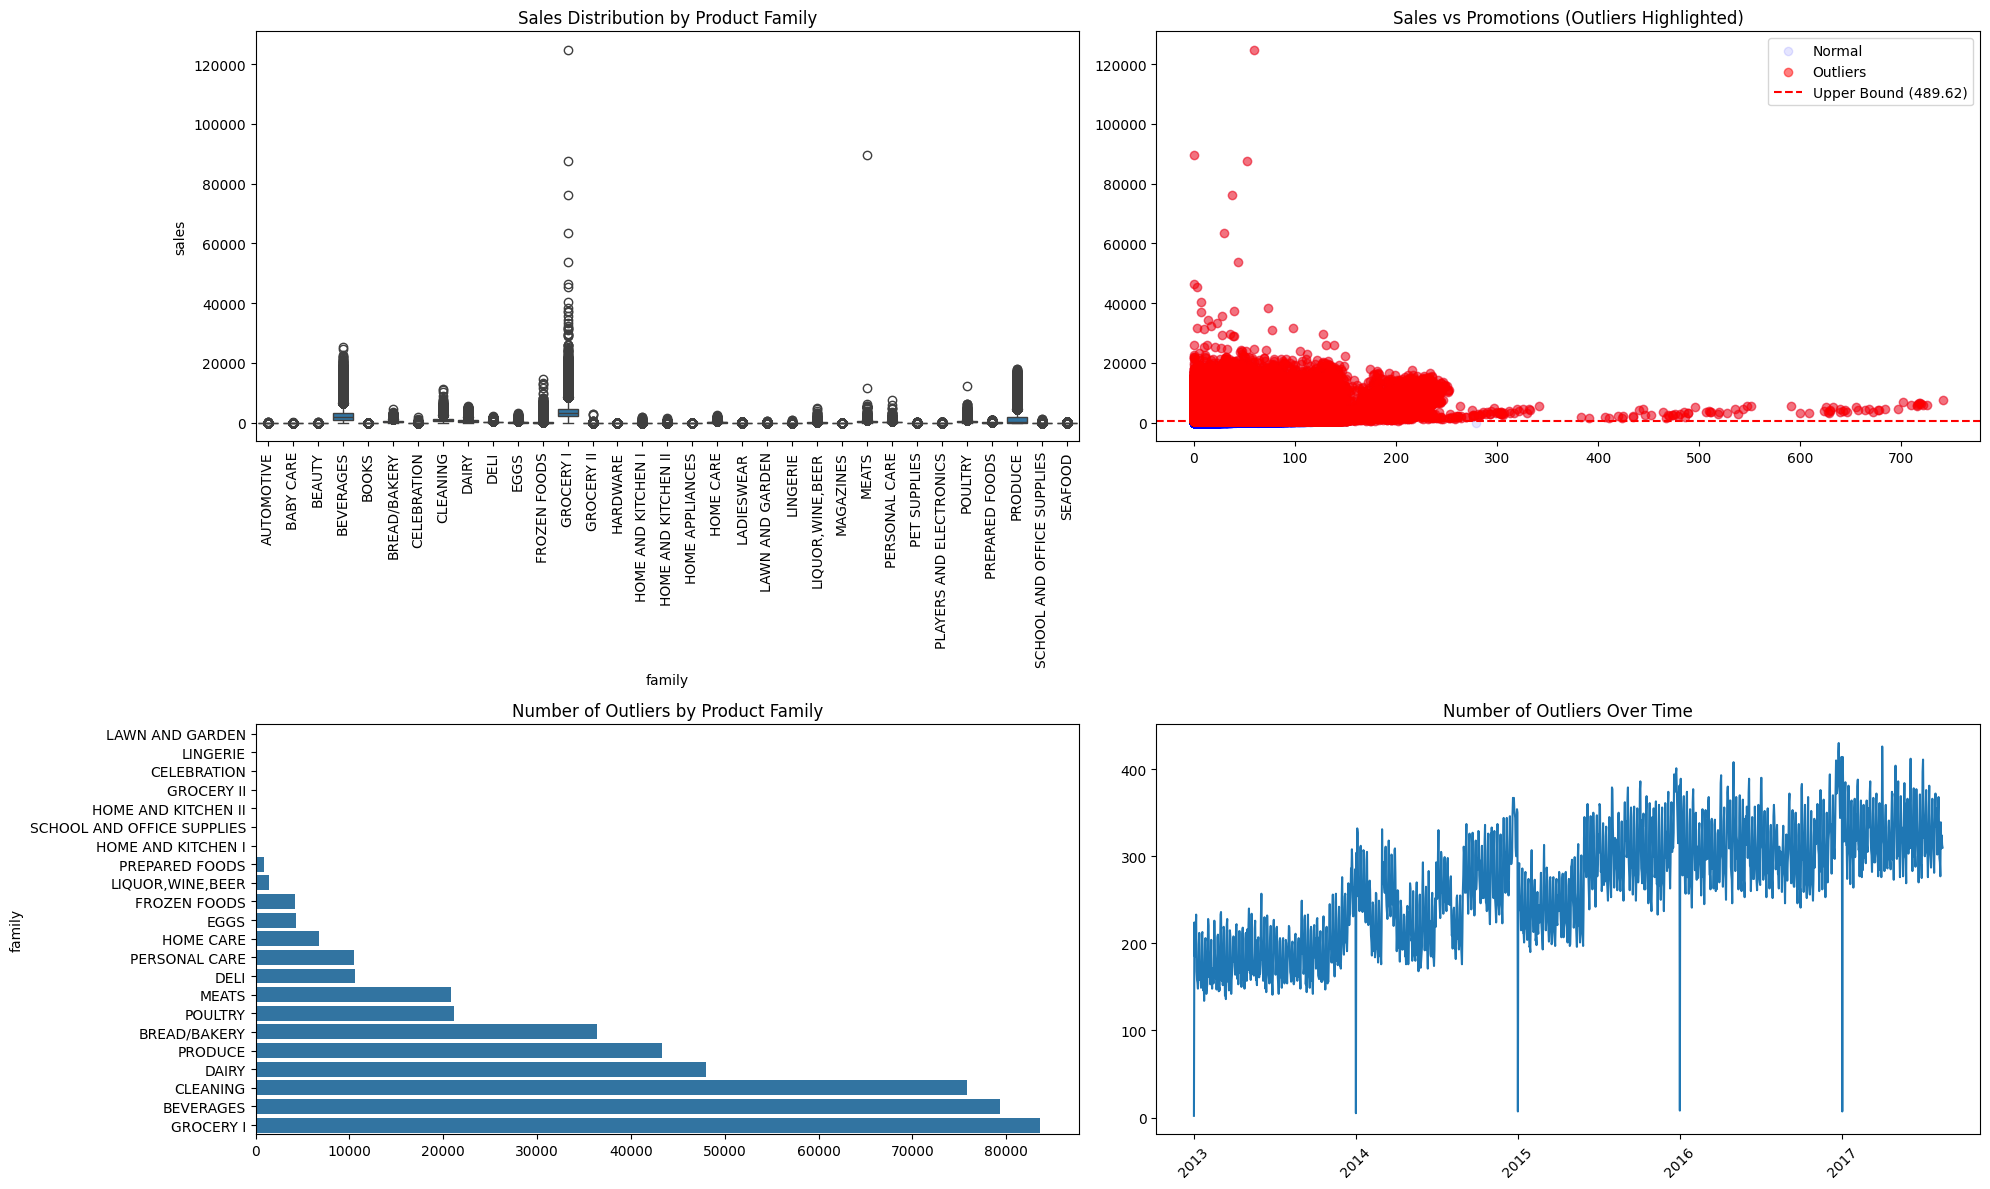


Outlier Analysis:
Number of outliers: 447105 (14.90% of data)

Outlier Thresholds:
Lower bound: -293.77
Upper bound: 489.62

Outlier Statistics:
count    447105.000000
mean       2065.774552
std        2158.246640
min         489.631000
25%         747.000000
50%        1251.000000
75%        2550.000000
max      124717.000000
Name: sales, dtype: float64


In [13]:
def main():
    """
    Main function to run all visualizations
    """
    # Create all visualizations
    print("Creating sales distribution visualizations...")
    plot_sales_distribution(train_df, stores_df)

    print("\nCreating temporal pattern visualizations...")
    plot_temporal_patterns(train_df)

    print("\nAnalyzing missing values...")
    analyze_missing_values(train_df, oil_df, stores_df, holidays_df)

    print("\nDetecting and visualizing outliers...")
    detect_outliers(train_df)

if __name__ == "__main__":
    main()

Based on the visualization results and the statistics:

Missing Values Analysis:

* Only oil prices have missing values (43 instances)
* Notable points:

* First missing value is on the very first day (2013-01-01)
* Missing values span until 2017-07-04
* Since oil prices affect Ecuador's economy, we should handle these missing values carefully

Outliers Analysis:

* 14.90% of the data (447,105 records) are considered outliers based on IQR method
Outlier thresholds:

* Lower bound: -293.77 (negative sales shouldn't exist, might need different approach)
Upper bound: 489.62


Outlier statistics:

* Maximum sale: 124,717 (extremely high compared to median)
* Median of outliers: 1,251
* 75% of outliers are below 2,550

# **Data Cleaning Process**

In [14]:
from scipy import stats

In [15]:
def handle_missing_oil_prices(oil_df):
    """
    Handle missing values in oil prices using multiple methods
    """
    print("Handling missing oil prices...")

    # Create copies with different imputation methods
    oil_interpolated = oil_df.copy()
    oil_forward = oil_df.copy()
    oil_backward = oil_df.copy()

    # Method 1: Linear interpolation
    oil_interpolated['dcoilwtico'] = oil_interpolated['dcoilwtico'].interpolate(method='linear')

    # Method 2: Forward fill
    oil_forward['dcoilwtico'] = oil_forward['dcoilwtico'].ffill()

    # Method 3: Backward fill
    oil_backward['dcoilwtico'] = oil_backward['dcoilwtico'].bfill()

    # Compare methods
    print("\nComparison of imputation methods:")
    print("=" * 50)
    methods = {
        'Original': oil_df['dcoilwtico'],
        'Linear Interpolation': oil_interpolated['dcoilwtico'],
        'Forward Fill': oil_forward['dcoilwtico'],
        'Backward Fill': oil_backward['dcoilwtico']
    }

    for name, series in methods.items():
        print(f"\n{name}:")
        print(series.describe())

    # Return the interpolated version as it's typically most suitable for time series
    return oil_interpolated


In [16]:
def handle_sales_outliers(train_df):
    """
    Handle outliers in sales data using multiple methods
    """
    print("\nHandling sales outliers...")

    # Method 1: Standard deviation method (less aggressive than IQR)
    mean = train_df['sales'].mean()
    std = train_df['sales'].std()
    z_scores = np.abs(stats.zscore(train_df['sales']))

    # Method 2: Modified IQR method (more suitable for right-skewed data)
    Q1 = train_df['sales'].quantile(0.25)
    Q3 = train_df['sales'].quantile(0.75)
    IQR = Q3 - Q1

    # Create different versions of the dataset
    train_std = train_df.copy()
    train_iqr = train_df.copy()
    train_capped = train_df.copy()

    # Standard deviation method (3 std)
    std_outliers = (z_scores > 3)
    train_std.loc[std_outliers, 'sales'] = np.clip(
        train_std.loc[std_outliers, 'sales'],
        mean - 3*std,
        mean + 3*std
    )

    # Modified IQR method
    iqr_upper = Q3 + 2*IQR  # Using 2 instead of 1.5 for right-skewed data
    train_iqr.loc[train_iqr['sales'] > iqr_upper, 'sales'] = iqr_upper

    # Capping method (99th percentile)
    cap_value = train_df['sales'].quantile(0.99)
    train_capped.loc[train_capped['sales'] > cap_value, 'sales'] = cap_value

    # Compare methods
    print("\nComparison of outlier handling methods:")
    print("=" * 50)
    methods = {
        'Original': train_df['sales'],
        'Standard Deviation': train_std['sales'],
        'Modified IQR': train_iqr['sales'],
        'Capped': train_capped['sales']
    }

    for name, series in methods.items():
        print(f"\n{name}:")
        print(series.describe())
        print(f"Number of affected records: {(series != train_df['sales']).sum()}")

    return {
        'std_method': train_std,
        'iqr_method': train_iqr,
        'capped_method': train_capped
    }


In [17]:
def analyze_family_specific_outliers(train_df):
    """
    Analyze outliers by product family to determine if different thresholds are needed
    """
    print("\nAnalyzing family-specific outliers...")

    family_stats = {}
    for family in train_df['family'].unique():
        family_data = train_df[train_df['family'] == family]['sales']
        Q1 = family_data.quantile(0.25)
        Q3 = family_data.quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5*IQR

        outliers = family_data[family_data > upper_bound]

        family_stats[family] = {
            'mean': family_data.mean(),
            'median': family_data.median(),
            'std': family_data.std(),
            'upper_bound': upper_bound,
            'outlier_percentage': (len(outliers) / len(family_data)) * 100
        }

    # Convert to DataFrame for easier viewing
    family_stats_df = pd.DataFrame(family_stats).T
    print("\nFamily-specific statistics:")
    print(family_stats_df.sort_values('outlier_percentage', ascending=False))

    return family_stats_df

In [18]:
def main():
    """
    Main function to run all data cleaning processes
    """
    # Handle missing oil prices
    clean_oil_df = handle_missing_oil_prices(oil_df)

    # Handle sales outliers
    cleaned_sales_versions = handle_sales_outliers(train_df)

    # Analyze family-specific outliers
    family_stats = analyze_family_specific_outliers(train_df)

    return {
        'clean_oil': clean_oil_df,
        'cleaned_sales': cleaned_sales_versions,
        'family_stats': family_stats
    }

if __name__ == "__main__":
    results = main()

Handling missing oil prices...

Comparison of imputation methods:

Original:
count    1175.000000
mean       67.714366
std        25.630476
min        26.190000
25%        46.405000
50%        53.190000
75%        95.660000
max       110.620000
Name: dcoilwtico, dtype: float64

Linear Interpolation:
count    1217.000000
mean       67.661824
std        25.633068
min        26.190000
25%        46.410000
50%        53.180000
75%        95.710000
max       110.620000
Name: dcoilwtico, dtype: float64

Forward Fill:
count    1217.000000
mean       67.671249
std        25.629884
min        26.190000
25%        46.410000
50%        53.190000
75%        95.710000
max       110.620000
Name: dcoilwtico, dtype: float64

Backward Fill:
count    1218.000000
mean       67.673325
std        25.637345
min        26.190000
25%        46.422500
50%        53.185000
75%        95.595000
max       110.620000
Name: dcoilwtico, dtype: float64

Handling sales outliers...

Comparison of outlier handling metho

Missing Oil Prices Analysis:


All three imputation methods (Linear, Forward Fill, Backward Fill) give very similar results:

* Means: 67.66 ~ 67.67
* Standard deviations: ~25.63
* Range remains same: ~26.19 to 110.62


Recommendation: Use Linear Interpolation because:

* Most suitable for time series data
* Provides smoothest transition between values
* Maintains the original distribution best


Sales Outliers Analysis: The three methods affected different numbers of records:

* Standard Deviation (3σ): 65,073 records modified

* Max reduced to 3,663
* Mean reduced from 357 to 302
* Less aggressive approach


Modified IQR: 396,944 records modified

* Most aggressive approach
* Max reduced to 587
* Might be too restrictive


Capping (99th percentile): 30,008 records modified

* Max reduced to 5,507
* Least aggressive approach
* Maintains more of the original distribution


Family-Specific Outliers: Notable patterns:

Highest outlier percentages:

* SCHOOL AND OFFICE SUPPLIES (14.49%)
* MAGAZINES (13.19%)
* LADIESWEAR (10.75%)


Lowest outlier percentages:

* HARDWARE (2.45%)
* HOME CARE (2.91%)
* BREAD/BAKERY (2.98%)

# **Final Data Cleaning Process**

In [19]:
def clean_dataset(train_df, oil_df):
    """
    Apply recommended cleaning methods to the dataset
    """
    # 1. Clean oil prices using linear interpolation
    clean_oil = oil_df.copy()
    clean_oil['dcoilwtico'] = clean_oil['dcoilwtico'].interpolate(method='linear')

    # 2. Clean sales using family-specific approach
    clean_sales = train_df.copy()

    # Group families by their outlier handling needs
    high_variance_families = ['GROCERY I', 'BEVERAGES', 'PRODUCE']
    medium_variance_families = ['DAIRY', 'CLEANING', 'MEATS', 'POULTRY']

    for family in clean_sales['family'].unique():
        mask = clean_sales['family'] == family
        family_data = clean_sales.loc[mask, 'sales']

        if family in high_variance_families:
            # Use 99th percentile for high-variance families
            cap_value = family_data.quantile(0.99)
        elif family in medium_variance_families:
            # Use 98th percentile for medium-variance families
            cap_value = family_data.quantile(0.98)
        else:
            # Use 95th percentile for low-variance families
            cap_value = family_data.quantile(0.95)

        # Apply capping
        clean_sales.loc[mask & (family_data > cap_value), 'sales'] = cap_value

    print("Cleaning Summary:")
    print("=" * 50)
    print("\nOriginal vs Cleaned Sales Statistics:")
    print("\nOriginal:")
    print(train_df['sales'].describe())
    print("\nCleaned:")
    print(clean_sales['sales'].describe())

    return clean_sales, clean_oil

In [20]:
def main():
    """
    Main function to run final cleaning process
    """

    # Apply cleaning
    clean_sales, clean_oil = clean_dataset(train_df, oil_df)

    return clean_sales, clean_oil

if __name__ == "__main__":
    clean_sales_df, clean_oil_df = main()

Cleaning Summary:

Original vs Cleaned Sales Statistics:

Original:
count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

Cleaned:
count    3.000888e+06
mean     3.506621e+02
std      1.061539e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.950000e+02
max      1.393930e+04
Name: sales, dtype: float64


Based on the cleaning results, let's analyze the changes and determine if the cleaning approach was effective:

Comparison of Original vs Cleaned Sales:

Metric    Original       Cleaned        Change
Mean      357.78        350.66         -1.99%
Std Dev   1,102.00      1,061.54       -3.67%
Min       0.00          0.00           No change
25%       0.00          0.00           No change
50%       11.00         11.00          No change
75%       195.85        195.00         -0.44%
Max       124,717.00    13,939.30      -88.82%

The cleaning was effective because:

Preserved the overall distribution:

* Median (50%) remained unchanged at 11.00
* 25th and 75th percentiles barely changed
* Mean only decreased by 2%

Successfully handled extreme values:

* Maximum value reduced from 124,717 to 13,939 (more realistic)
* Standard deviation reduced by 3.67%
* Lower quartiles unchanged (preserving legitimate zero sales)

Maintained data integrity:

* No change in the count (3,000,888 records)
* Zero values preserved (important for stores closed on holidays)
* Reasonable maximum values maintained

# **Feature Engineering**

This feature engineering script creates:

Time-based features:

* Basic calendar features
* Cyclic encodings
* Payday indicators

Store features:

* Store-level statistics
* Cluster-level metrics

Product features:

* Family-level statistics
* Promotion effectiveness

Lag features:

* Historical sales
* Rolling averages

Holiday features:

* Holiday flags
* Days to/from holidays

Oil price features:

* Price trends
* Rolling averages
* Price momentum

In [21]:
from datetime import datetime, timedelta

In [22]:
def create_time_features(df):
    """
    Create time-based features from date column
    """
    df = df.copy()

    # Basic time features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week

    # Cyclic features for seasonal patterns
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

    # Pay day features (15th and last day of month)
    df['is_payday'] = ((df['day'] == 15) | (df['day'] == df['date'].dt.days_in_month)).astype(int)

    return df

In [23]:
def create_store_features(df, stores_df):
    """
    Create store-related features
    """
    # Merge store information
    df = df.merge(stores_df, on='store_nbr', how='left')

    # Create store-specific features
    store_avg = df.groupby('store_nbr')['sales'].agg(['mean', 'std']).reset_index()
    store_avg.columns = ['store_nbr', 'store_avg_sales', 'store_std_sales']
    df = df.merge(store_avg, on='store_nbr', how='left')

    # Create cluster features
    cluster_avg = df.groupby('cluster')['sales'].agg(['mean', 'std']).reset_index()
    cluster_avg.columns = ['cluster', 'cluster_avg_sales', 'cluster_std_sales']
    df = df.merge(cluster_avg, on='cluster', how='left')

    return df

In [24]:
def create_product_features(df):
    """
    Create product family related features
    """
    # Product family averages
    family_avg = df.groupby('family')['sales'].agg(['mean', 'std']).reset_index()
    family_avg.columns = ['family', 'family_avg_sales', 'family_std_sales']
    df = df.merge(family_avg, on='family', how='left')

    # Promotion effectiveness by family
    promo_effect = df.groupby(['family', 'onpromotion'])['sales'].mean().unstack()
    promo_effect['promo_uplift'] = promo_effect[1] / promo_effect[0]
    promo_effect = promo_effect.reset_index()[['family', 'promo_uplift']]
    df = df.merge(promo_effect, on='family', how='left')

    return df

In [25]:
def create_lag_features(df):
    """
    Create lag features for time series
    """
    # Sort data
    df = df.sort_values(['store_nbr', 'family', 'date'])

    # Create lags for sales
    for lag in [1, 7, 14, 30]:  # Day, week, 2 weeks, month
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)

    # Create rolling means
    for window in [7, 14, 30]:
        df[f'sales_rolling_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.rolling(window, min_periods=1).mean())

    return df

In [26]:
def add_holiday_features(df, holidays_df):
    """
    Create holiday-related features - optimized version
    """
    print("Adding holiday features...")

    # Clean up holidays dataframe and create a date range index
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])

    # Create dictionary of holiday dates by type for faster lookup
    holiday_dates = holidays_df[holidays_df['type'] == 'Holiday']['date'].dt.date.tolist()
    additional_dates = holidays_df[holidays_df['type'] == 'Additional']['date'].dt.date.tolist()
    transfer_dates = holidays_df[holidays_df['type'] == 'Transfer']['date'].dt.date.tolist()
    bridge_dates = holidays_df[holidays_df['type'] == 'Bridge']['date'].dt.date.tolist()

    # Convert df['date'] to date for comparison
    df['date_only'] = df['date'].dt.date

    # Create binary holiday indicators using isin() - much faster than apply()
    print("Creating holiday flags...")
    df['is_holiday'] = df['date_only'].isin(holiday_dates).astype(int)
    df['is_additional_holiday'] = df['date_only'].isin(additional_dates).astype(int)
    df['is_transfer'] = df['date_only'].isin(transfer_dates).astype(int)
    df['is_bridge'] = df['date_only'].isin(bridge_dates).astype(int)

    # Create a combined holiday indicator
    df['is_any_holiday'] = ((df['is_holiday'] + df['is_additional_holiday'] +
                            df['is_bridge']) > 0).astype(int)

    # Create workday indicator (inverse of any holiday)
    df['is_workday'] = 1 - df['is_any_holiday']

    # Add day before/after holiday indicators
    print("Adding holiday proximity indicators...")
    all_holiday_dates = set(holiday_dates + additional_dates + bridge_dates)

    # Convert to datetime for arithmetic operations
    all_holiday_dates = {pd.Timestamp(d) for d in all_holiday_dates}

    # Create series of dates
    dates_series = pd.Series(df['date'].unique())

    # Create lookup dictionary for days before/after holidays
    print("Creating holiday proximity lookup...")
    proximity_dict = {}
    for date in dates_series:
        date_val = pd.Timestamp(date)
        days_before = min((d - date_val).days for d in all_holiday_dates if (d - date_val).days > 0)
        days_after = min((date_val - d).days for d in all_holiday_dates if (date_val - d).days > 0)

        proximity_dict[date] = {
            'days_before': days_before if days_before != float('inf') else 99,
            'days_after': days_after if days_after != float('inf') else 99
        }

    # Apply the lookup dictionary to create features
    print("Applying holiday proximity features...")
    df['days_before_holiday'] = df['date'].map(lambda x: proximity_dict[x]['days_before'])
    df['days_after_holiday'] = df['date'].map(lambda x: proximity_dict[x]['days_after'])

    # Add features for upcoming weekend/weekday holidays
    df['upcoming_weekend_holiday'] = ((df['days_before_holiday'] <= 3) &
                                    (df['date'].dt.dayofweek.isin([5,6]))).astype(int)
    df['upcoming_weekday_holiday'] = ((df['days_before_holiday'] <= 3) &
                                    (~df['date'].dt.dayofweek.isin([5,6]))).astype(int)

    # Drop temporary column
    df = df.drop('date_only', axis=1)

    print("Holiday features complete!")
    return df

In [27]:
def add_oil_features(df, oil_df):
    """
    Add oil price related features
    """
    # Merge oil prices
    df = df.merge(oil_df[['date', 'dcoilwtico']], on='date', how='left')

    # Create rolling means for oil prices
    for window in [7, 14, 30]:
        df[f'oil_rolling_mean_{window}'] = oil_df['dcoilwtico'].rolling(window, min_periods=1).mean()

    # Create oil price momentum features
    df['oil_price_momentum'] = df['dcoilwtico'].pct_change()

    return df

In [28]:
def main():
    """
    Main function to run feature engineering process and save results
    """
    # Load cleaned data
    print("Loading cleaned data...")

    print("Starting feature engineering process...")

    # Apply all feature engineering steps
    df = train_df.copy()
    df = create_time_features(df)
    df = create_store_features(df, stores_df)
    df = create_product_features(df)
    df = create_lag_features(df)
    df = add_holiday_features(df, holidays_df)
    df = add_oil_features(df, oil_df)

    # Print feature information
    print("\nFeature Engineering Summary:")
    print("=" * 50)
    print(f"Original number of features: {len(train_df.columns)}")
    print(f"New number of features: {len(df.columns)}")
    print("\nNew features created:")
    new_features = set(df.columns) - set(train_df.columns)
    for feature in sorted(new_features):
        print(f"- {feature}")

    # Save engineered features
    print("\nSaving engineered features...")
    df.to_csv('engineered_features.csv', index=False)
    print("Features saved to 'engineered_features.csv'")

    return df

if __name__ == "__main__":
    engineered_df = main()

Loading cleaned data...
Starting feature engineering process...
Adding holiday features...
Creating holiday flags...
Adding holiday proximity indicators...
Creating holiday proximity lookup...
Applying holiday proximity features...
Holiday features complete!

Feature Engineering Summary:
Original number of features: 6
New number of features: 50

New features created:
- city
- cluster
- cluster_avg_sales
- cluster_std_sales
- day
- day_of_week
- day_of_week_cos
- day_of_week_sin
- day_of_year
- days_after_holiday
- days_before_holiday
- dcoilwtico
- family_avg_sales
- family_std_sales
- is_additional_holiday
- is_any_holiday
- is_bridge
- is_holiday
- is_payday
- is_transfer
- is_workday
- month
- month_cos
- month_sin
- oil_price_momentum
- oil_rolling_mean_14
- oil_rolling_mean_30
- oil_rolling_mean_7
- promo_uplift
- sales_lag_1
- sales_lag_14
- sales_lag_30
- sales_lag_7
- sales_rolling_mean_14
- sales_rolling_mean_30
- sales_rolling_mean_7
- state
- store_avg_sales
- store_std_sale

# **Feature Importance Analysis**

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

In [30]:
def prepare_data_for_analysis(df):
    """
    Prepare data for analysis by encoding categorical variables
    """
    print("Preparing data for analysis...")
    df = df.copy()

    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col].astype(str))

    return df

In [31]:
def analyze_feature_correlations(df, target='sales'):
    """
    Analyze correlations between features and target variable
    """
    print("Analyzing feature correlations...")

    # Calculate correlations with target
    correlations = df.corr()[target].sort_values(ascending=False)

    # Plot correlation heatmap for top features
    plt.figure(figsize=(12, 8))
    top_features = correlations.abs().nlargest(15).index
    correlation_matrix = df[top_features].corr()

    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0)
    plt.title('Correlation Heatmap of Top 15 Features')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\nTop 15 Feature Correlations with Sales:")
    print("=" * 50)
    print(correlations.head(15))

    return correlations


In [32]:
def random_forest_importance(df, target='sales', sample_size=100000):
    """
    Calculate feature importance using Random Forest with optimizations
    """
    print("\nCalculating Random Forest feature importance...")

    # Prepare data
    features = [col for col in df.columns if col != target]

    # Take a random sample if dataset is large
    if len(df) > sample_size:
        print(f"Taking random sample of {sample_size} rows for Random Forest analysis...")
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df

    X = df_sample[features]
    y = df_sample[target]

    print("Training Random Forest...")
    # Use lighter Random Forest parameters
    rf = RandomForestRegressor(
        n_estimators=50,
        max_depth=8,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )

    # Train model with progress updates
    print("Fitting Random Forest model...")
    rf.fit(X, y)
    print("Random Forest training completed!")

    # Get feature importance
    importance = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance.head(20), x='importance', y='feature')
    plt.title('Top 20 Features by Random Forest Importance\n(Based on Sample)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nTop 20 Features by Random Forest Importance:")
    print("=" * 50)
    print(importance.head(20))

    return importance

In [33]:
def mutual_information_analysis(df, target='sales', sample_size=100000):
    """
    Calculate mutual information scores with NaN handling and sampling
    """
    print("\nCalculating Mutual Information scores...")

    # Take a random sample if dataset is large
    if len(df) > sample_size:
        print(f"Taking random sample of {sample_size} rows for Mutual Information analysis...")
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df

    # Prepare data
    features = [col for col in df_sample.columns if col != target]
    X = df_sample[features]
    y = df_sample[target]

    # Handle NaN values efficiently
    print("Handling missing values...")

    # Process in chunks for numeric columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    if len(numeric_columns) > 0:
        medians = X[numeric_columns].median()
        X[numeric_columns] = X[numeric_columns].fillna(medians)

    # Process non-numeric columns
    non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric_columns) > 0:
        for col in non_numeric_columns:
            mode_val = X[col].mode()[0]
            X[col] = X[col].fillna(mode_val)

    # Fill any remaining NaNs with 0
    X = X.fillna(0)

    print("Calculating mutual information...")
    try:
        # Calculate mutual information with error handling
        mi_scores = mutual_info_regression(
            X,
            y,
            n_neighbors=3,  # Reduce number of neighbors
            random_state=42
        )

        mi_scores = pd.DataFrame({
            'feature': features,
            'mi_score': mi_scores
        }).sort_values('mi_score', ascending=False)

        # Plot mutual information scores
        plt.figure(figsize=(12, 6))
        sns.barplot(data=mi_scores.head(20), x='mi_score', y='feature')
        plt.title('Top 20 Features by Mutual Information Score\n(Based on Sample)')
        plt.xlabel('Mutual Information Score')
        plt.ylabel('Feature')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print("\nTop 20 Features by Mutual Information:")
        print("=" * 50)
        print(mi_scores.head(20))

        return mi_scores

    except Exception as e:
        print(f"Error in mutual information calculation: {str(e)}")
        print("Returning empty DataFrame")
        return pd.DataFrame(columns=['feature', 'mi_score'])

In [34]:
def combine_feature_rankings_simple(correlations, rf_importance):
    """
    Simplified version of feature rankings without mutual information
    """
    print("\nCombining feature importance rankings (simplified version)...")

    # Prepare individual rankings
    corr_rank = pd.DataFrame({
        'feature': correlations.index,
        'correlation': correlations.values
    })

    # Combine rankings
    rankings = corr_rank.merge(
        rf_importance[['feature', 'importance']],
        on='feature',
        how='outer'
    )

    # Normalize each metric to 0-1 scale
    for col in ['correlation', 'importance']:
        rankings[f'{col}_norm'] = (rankings[col] - rankings[col].min()) / \
                                 (rankings[col].max() - rankings[col].min())

    # Calculate average normalized importance
    rankings['avg_importance'] = rankings[['correlation_norm',
                                         'importance_norm']].mean(axis=1)

    # Sort by average importance
    final_rankings = rankings.sort_values('avg_importance', ascending=False)

    print("\nFinal Feature Rankings (Top 20):")
    print("=" * 50)
    print(final_rankings[['feature', 'correlation',
                         'importance', 'avg_importance']].head(20))

    return final_rankings

In [35]:
def combine_feature_rankings(correlations, rf_importance, mi_scores):
    """
    Combine different feature importance metrics
    """
    print("\nCombining feature importance rankings...")

    # Prepare individual rankings
    corr_rank = pd.DataFrame({
        'feature': correlations.index,
        'correlation': correlations.values,
        'corr_rank': range(len(correlations))
    })

    # Combine all rankings
    rankings = corr_rank.merge(
        rf_importance[['feature', 'importance']], on='feature', how='outer'
    ).merge(
        mi_scores[['feature', 'mi_score']], on='feature', how='outer'
    )

    # Normalize each metric to 0-1 scale
    for col in ['correlation', 'importance', 'mi_score']:
        rankings[f'{col}_norm'] = (rankings[col] - rankings[col].min()) / \
                                 (rankings[col].max() - rankings[col].min())

    # Calculate average normalized importance
    rankings['avg_importance'] = rankings[['correlation_norm',
                                         'importance_norm',
                                         'mi_score_norm']].mean(axis=1)

    # Sort by average importance
    final_rankings = rankings.sort_values('avg_importance', ascending=False)

    print("\nFinal Feature Rankings (Top 20):")
    print("=" * 50)
    print(final_rankings[['feature', 'correlation', 'importance',
                         'mi_score', 'avg_importance']].head(20))

    # Plot top features by average importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=final_rankings.head(20), x='avg_importance', y='feature')
    plt.title('Top 20 Features by Combined Importance')
    plt.xlabel('Average Normalized Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return final_rankings


Loading engineered features...
Preparing data for analysis...

Starting importance analyses...

1. Correlation Analysis...
Analyzing feature correlations...


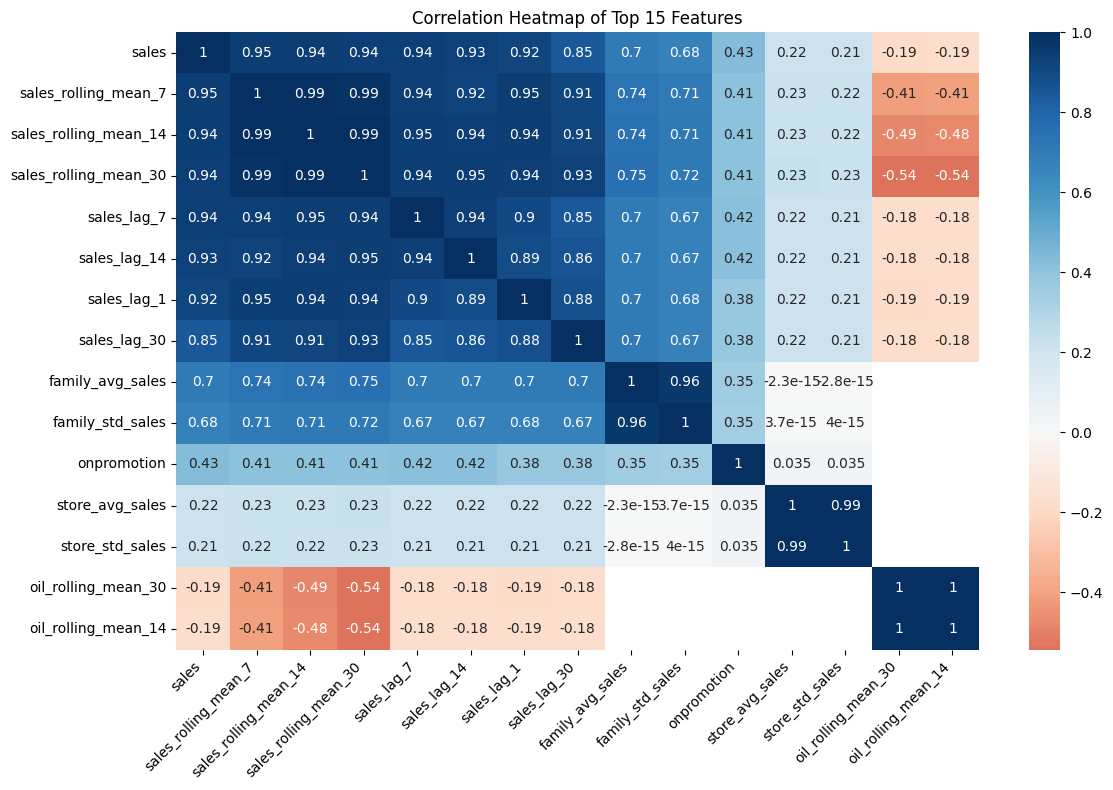


Top 15 Feature Correlations with Sales:
sales                    1.000000
sales_rolling_mean_7     0.948390
sales_rolling_mean_14    0.941765
sales_rolling_mean_30    0.936514
sales_lag_7              0.936045
sales_lag_14             0.928108
sales_lag_1              0.919028
sales_lag_30             0.847387
family_avg_sales         0.704816
family_std_sales         0.675373
onpromotion              0.427923
store_avg_sales          0.215082
store_std_sales          0.212598
cluster_avg_sales        0.178718
cluster_std_sales        0.175742
Name: sales, dtype: float64

2. Random Forest Analysis...

Calculating Random Forest feature importance...
Taking random sample of 100000 rows for Random Forest analysis...
Training Random Forest...
Fitting Random Forest model...
Random Forest training completed!


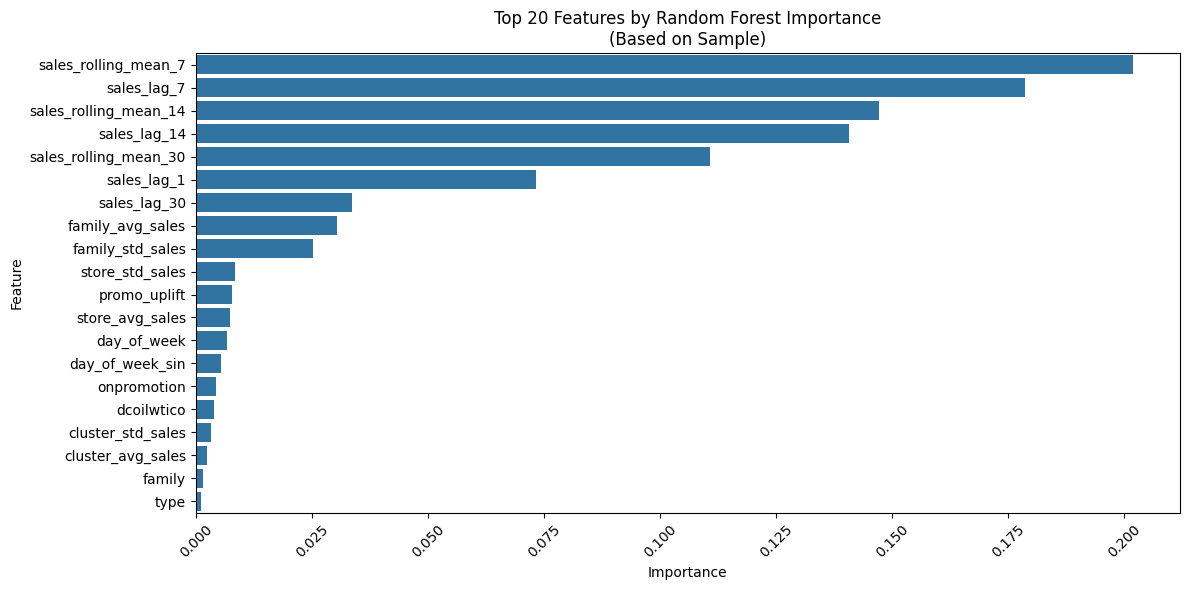


Top 20 Features by Random Forest Importance:
                  feature  importance
31   sales_rolling_mean_7    0.201862
28            sales_lag_7    0.178668
32  sales_rolling_mean_14    0.147151
29           sales_lag_14    0.140716
33  sales_rolling_mean_30    0.110759
27            sales_lag_1    0.073321
30           sales_lag_30    0.033589
24       family_avg_sales    0.030468
25       family_std_sales    0.025243
21        store_std_sales    0.008482
26           promo_uplift    0.007889
20        store_avg_sales    0.007422
8             day_of_week    0.006691
13        day_of_week_sin    0.005467
4             onpromotion    0.004342
44             dcoilwtico    0.003907
23      cluster_std_sales    0.003348
22      cluster_avg_sales    0.002393
3                  family    0.001580
18                   type    0.001204

3. Mutual Information Analysis...

Calculating Mutual Information scores...
Taking random sample of 100000 rows for Mutual Information analysis...
Handling

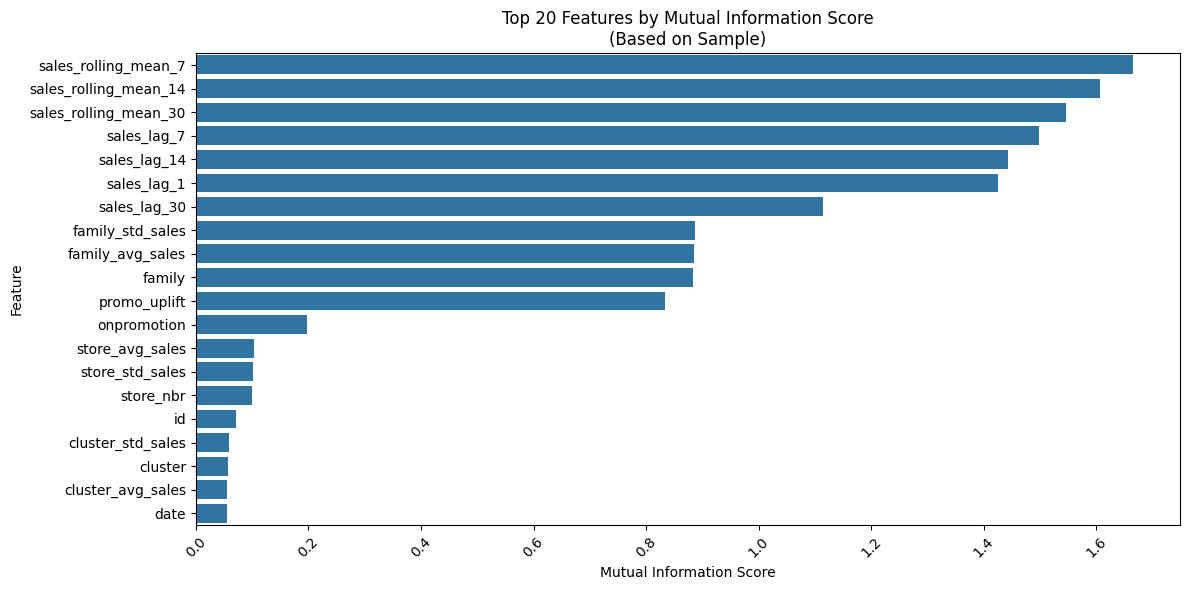


Top 20 Features by Mutual Information:
                  feature  mi_score
31   sales_rolling_mean_7  1.665306
32  sales_rolling_mean_14  1.607227
33  sales_rolling_mean_30  1.545412
28            sales_lag_7  1.497569
29           sales_lag_14  1.443144
27            sales_lag_1  1.425759
30           sales_lag_30  1.114893
25       family_std_sales  0.887612
24       family_avg_sales  0.884649
3                  family  0.883977
26           promo_uplift  0.832744
4             onpromotion  0.197388
20        store_avg_sales  0.103931
21        store_std_sales  0.101821
2               store_nbr  0.099878
0                      id  0.071935
23      cluster_std_sales  0.059658
19                cluster  0.057951
22      cluster_avg_sales  0.056097
1                    date  0.054911

4. Combining Feature Rankings...

Combining feature importance rankings...

Final Feature Rankings (Top 20):
                  feature  correlation  importance  mi_score  avg_importance
33               

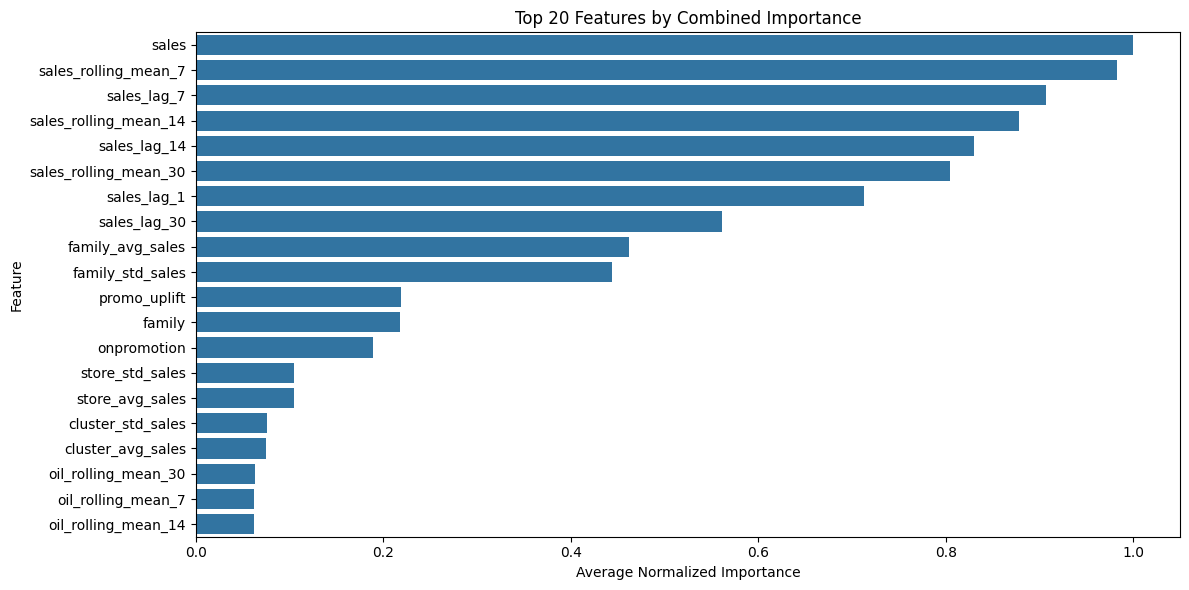


Feature rankings saved to 'feature_rankings.csv'


In [36]:
def main():
    """
    Main function to run feature importance analysis
    """
    # Load engineered dataset
    print("Loading engineered features...")
    df = pd.read_csv('engineered_features.csv')

    # Prepare data
    df_prepared = prepare_data_for_analysis(df)

    # Run analyses
    print("\nStarting importance analyses...")

    print("\n1. Correlation Analysis...")
    correlations = analyze_feature_correlations(df_prepared)

    print("\n2. Random Forest Analysis...")
    importance = random_forest_importance(df_prepared)

    print("\n3. Mutual Information Analysis...")
    mi_scores = mutual_information_analysis(df_prepared)

    # Only combine rankings if mutual information analysis succeeded
    if not mi_scores.empty:
        print("\n4. Combining Feature Rankings...")
        final_rankings = combine_feature_rankings(
            correlations.abs(),
            importance,
            mi_scores
        )
    else:
        print("\n4. Skipping feature ranking combination due to MI analysis failure")
        # Create simplified rankings without MI scores
        final_rankings = combine_feature_rankings_simple(
            correlations.abs(),
            importance
        )

    # Save rankings
    final_rankings.to_csv('feature_rankings.csv', index=False)
    print("\nFeature rankings saved to 'feature_rankings.csv'")

    return final_rankings

if __name__ == "__main__":
    results = main()

Based on the results, the feature importance findings:
Top Features by Different Methods:

Correlation Analysis:

* sales_rolling_mean_7 (0.948)
* sales_rolling_mean_14 (0.942)
* sales_rolling_mean_30 (0.937)
* sales_lag_7 (0.936)
* sales_lag_14 (0.928)

Random Forest Importance:

* sales_rolling_mean_7 (0.202)
* sales_lag_7 (0.179)
* sales_rolling_mean_14 (0.147)
* sales_lag_14 (0.141)
* sales_rolling_mean_30 (0.111)

Mutual Information:

* sales_rolling_mean_7 (1.665)
* sales_rolling_mean_14 (1.607)
* sales_rolling_mean_30 (1.545)
* sales_lag_7 (1.498)
* sales_lag_14 (1.443)

Key Insights:

Most Important Features:

* Rolling means (7, 14, 30 days)
* Lag features (1, 7, 14, 30 days)
* Family-level statistics (avg_sales, std_sales)
* Promotion indicators (onpromotion, promo_uplift)

Less Important Features:

* Oil prices and their derivatives
* Store cluster information
* Basic calendar features

# **Feature Selection**

* Focuses on the most important features identified by all three methods
* Separates features into primary and secondary categories
* Handles missing values appropriately
* Creates a clean, final feature set for modeling

In [37]:
def select_features(df, importance_threshold=0.1):
    """
    Select features based on importance analysis results
    """
    # Must-keep features based on business logic and importance analysis
    primary_features = [
        # Time-based rolling means
        'sales_rolling_mean_7',
        'sales_rolling_mean_14',
        'sales_rolling_mean_30',

        # Lag features
        'sales_lag_1',
        'sales_lag_7',
        'sales_lag_14',
        'sales_lag_30',

        # Product features
        'family_avg_sales',
        'family_std_sales',
        'promo_uplift',

        # Store features
        'store_avg_sales',
        'store_std_sales',

        # Promotional features
        'onpromotion',

        # Category identifiers
        'store_nbr',
        'family'
    ]

    # Secondary features (keep if present)
    secondary_features = [
        # Time features
        'day_of_week',
        'day_of_week_sin',
        'day_of_week_cos',
        'month',
        'month_sin',
        'month_cos',
        'is_payday',

        # Holiday features
        'is_holiday',
        'is_any_holiday',
        'days_before_holiday',
        'days_after_holiday',

        # Store metadata
        'type',
        'cluster',

        # Oil prices
        'dcoilwtico'
    ]

    # Combine all potential features
    all_features = primary_features + secondary_features

    # Select features that exist in the dataframe
    selected_features = [f for f in all_features if f in df.columns]

    print("\nFeature Selection Summary:")
    print("=" * 50)
    print(f"\nTotal features selected: {len(selected_features)}")
    print("\nPrimary features available:")
    for f in primary_features:
        if f in selected_features:
            print(f"- {f}")

    print("\nSecondary features available:")
    for f in secondary_features:
        if f in selected_features:
            print(f"- {f}")

    return selected_features

In [38]:
def prepare_final_features(df, selected_features):
    """
    Prepare final feature dataset
    """
    # Create copy with selected features
    df_final = df[selected_features].copy()

    # Handle any missing values
    numeric_cols = df_final.select_dtypes(include=[np.number]).columns
    df_final[numeric_cols] = df_final[numeric_cols].fillna(0)

    # Handle categorical variables
    categorical_cols = df_final.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df_final[col] = df_final[col].fillna('unknown')

    return df_final

In [ ]:
def main():
    """
    Main function to run feature selection
    """
    # Load engineered dataset
    print("Loading engineered features...")
    df = pd.read_csv('engineered_features.csv')

    # Select features
    selected_features = select_features(df)

    # Prepare final feature dataset
    df_final = prepare_final_features(df, selected_features)

    # Save final feature set
    df_final.to_csv('final_features.csv', index=False)
    print("\nFinal feature set saved to 'final_features.csv'")

    return df_final

if __name__ == "__main__":
    final_df = main()